In [1]:
import numpy as np
import trimesh
from scipy.stats import special_ortho_group
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from random import sample
import random
from ipywidgets import *
import visualkeras

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.


In [2]:
mesh = trimesh.load_mesh('surf14.ply')
V = np.array(mesh.vertices)

## Perform Generalized Procrustes to Generate Mean Shape

In [3]:
point_list = np.zeros(V.shape)

In [4]:
m = 112

figures = np.zeros((m, len(point_list), 3))

for k in range(m):
    stl_mesh = trimesh.load_mesh('surf' + str(1 + k) + '.ply')
    figures[k, :, :] = np.array(stl_mesh.vertices)

In [5]:
r = np.random.randint(112)
M = np.zeros(figures[r,:,:].shape)

for k in range(m):
    if k != r: 
        T, V_transformed, d = trimesh.registration.procrustes(figures[k,:,:], figures[r,:,:])
        M += V_transformed
    
M /= ( m - 1 )

for t in range(2):
    M_new = np.zeros(M.shape)
    total_d = []
    for k in range(m):
        T, V_transformed, d = trimesh.registration.procrustes(figures[k,:,:], M)
        total_d.append(d)
        M_new += V_transformed
    M = M_new
    M /= m
    
    if max(total_d) < 0.1:
        print("Converged!")
        break

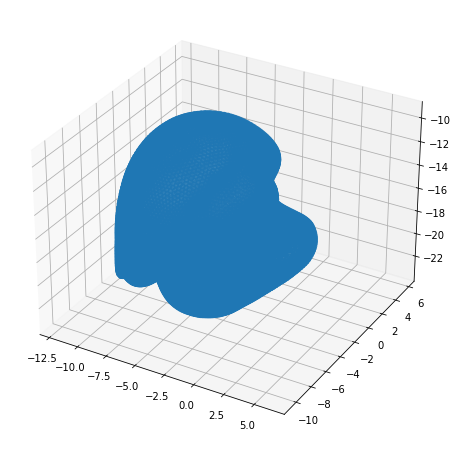

In [6]:
#%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(M[:,0], M[:,1], M[:,2])
plt.show()

In [7]:
for k in range(m):
    T, V_transformed, d = trimesh.registration.procrustes(figures[k,:,:], M)
    figures[k,:,:] = V_transformed

## Extract Voxelized Data

In [8]:
X_min = np.min(np.min(figures[:,:,0])) - 1
Y_min = np.min(np.min(figures[:,:,1])) - 1
Z_min = np.min(np.min(figures[:,:,2])) - 1

figures[:,:,0] = figures[:,:,0] - X_min
figures[:,:,1] = figures[:,:,1] - Y_min
figures[:,:,2] = figures[:,:,2] - Z_min

X_max = np.max(np.max(figures[:,:,0])) + 1
Y_max = np.max(np.max(figures[:,:,1])) + 1
Z_max = np.max(np.max(figures[:,:,2])) + 1

figures[:,:,0] /= X_max
figures[:,:,1] /= Y_max
figures[:,:,2] /= Z_max

In [9]:
mesh = trimesh.load_mesh('surf1.ply')
mesh.vertices = figures[0,:,:]

In [10]:
voxel_shapes = np.load("voxelized_meshes.npy")

In [11]:
voxel1 = voxel_shapes[69,:,:,:]

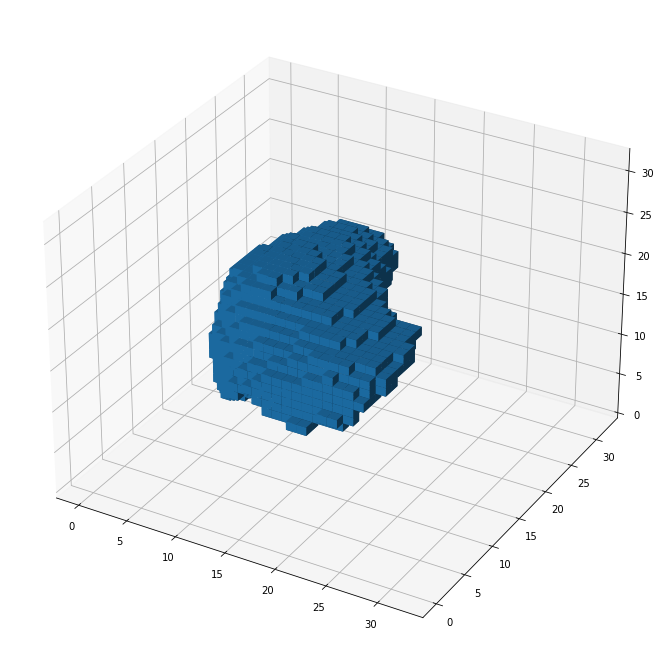

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.voxels(voxel1)

plt.show()

## Autoencode Latent Shape Space Architecture

In [13]:
encoding_dim = 128

In [14]:
input_imag = keras.Input(shape = (32,32,32,1))

x = layers.Conv3D(16, (5,5,5))(input_imag)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(8, (5,5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(4, (5,5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(2, (5,5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(1, (5,5,5))(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
encoded = layers.UnitNormalization()(x)

x = layers.Dense(1728)(encoded)
x = layers.Reshape((12,12,12,1))(x)
x = layers.Conv3D(2, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(4, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(8, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(1, (9,9,9))(x)
decoded = activations.sigmoid(x)

autoencoder = keras.Model(inputs=input_imag, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanSquaredError()])

2023-08-09 11:48:26.930615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 32, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 28, 28, 28, 16)    2016      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 28, 16)   64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 28, 16)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 24, 24, 24, 8)     16008     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 24, 8)    32        
 hNormalization)                                             

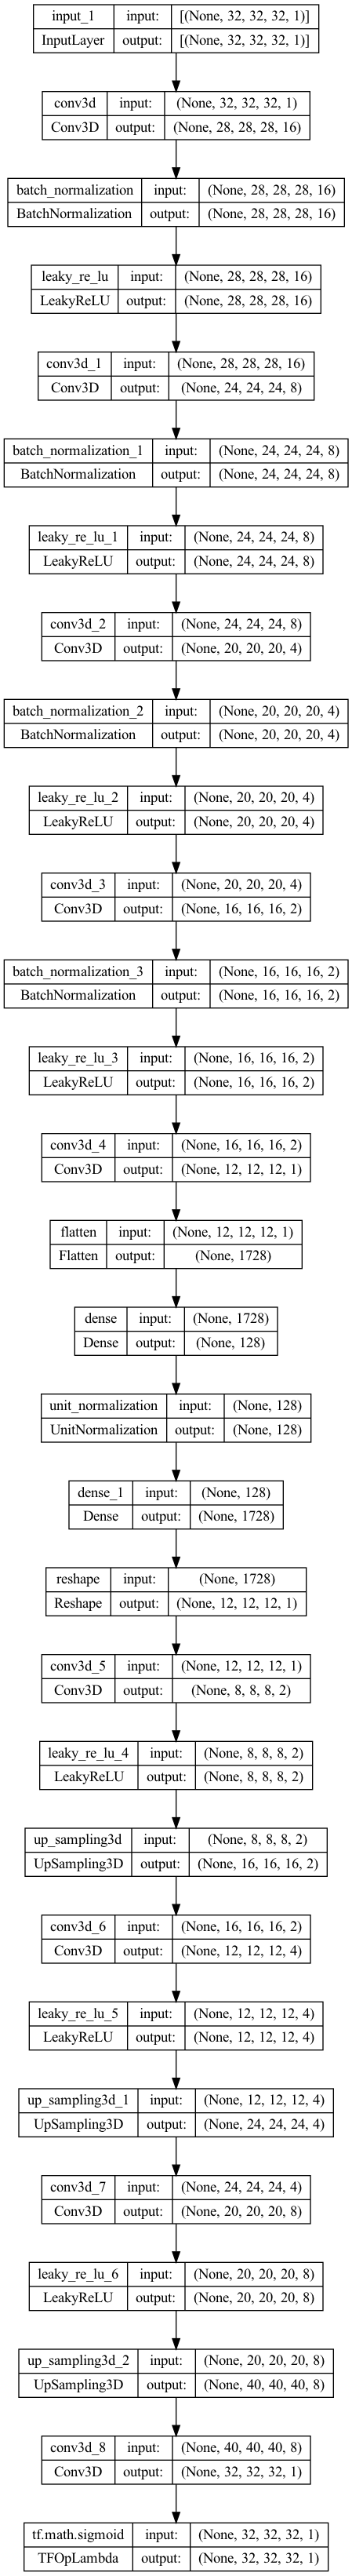

In [16]:
plot_model(autoencoder, to_file='pre_train_latent_dimension.png', show_shapes=True, show_layer_names=True)

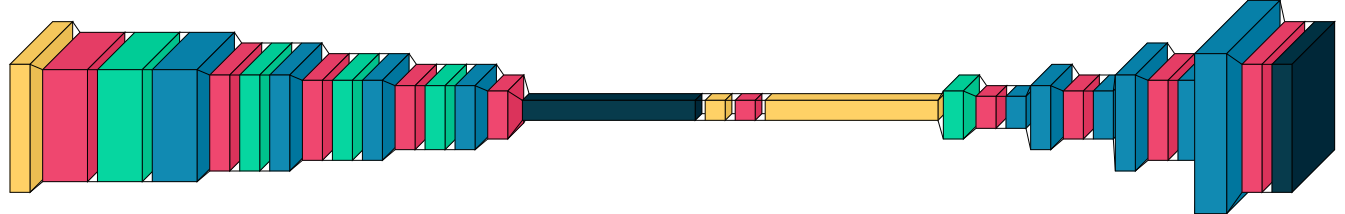

In [17]:
visualkeras.layered_view(autoencoder)

## Train / Test Split

In [18]:
random.seed(10)
test_indices = random.sample(range(m),23)
train_indices = list(filter(lambda x : x not in test_indices, range(m)))
val_indices = random.sample(train_indices,11)
train_indices = list(filter(lambda x : x not in val_indices, train_indices))

## Model Training

In [19]:
training_shapes = voxel_shapes[train_indices, :, :, :]
val_shapes = voxel_shapes[val_indices, :, :, :]
test_shapes = voxel_shapes[test_indices, :, :, :]

In [20]:
training_shapes.shape

(78, 32, 32, 32)

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_with_normalization_32.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [22]:
autoencoder.fit(training_shapes, training_shapes, epochs=200, batch_size=10, shuffle=True, validation_data=(val_shapes, val_shapes), callbacks=[es,mc])

Epoch 1/200
8/8 [==============================] - ETA: 0s - loss: 0.4595 - mean_squared_error: 0.1448
Epoch 1: val_loss improved from inf to 0.59735, saving model to best_model_with_normalization_32.h5
8/8 [==============================] - 11s 1s/step - loss: 0.4595 - mean_squared_error: 0.1448 - val_loss: 0.5974 - val_mean_squared_error: 0.2020
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.1895 - mean_squared_error: 0.0564
Epoch 2: val_loss did not improve from 0.59735
8/8 [==============================] - 10s 1s/step - loss: 0.1895 - mean_squared_error: 0.0564 - val_loss: 0.6568 - val_mean_squared_error: 0.1497
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.1171 - mean_squared_error: 0.0357
Epoch 3: val_loss did not improve from 0.59735
8/8 [==============================] - 10s 1s/step - loss: 0.1171 - mean_squared_error: 0.0357 - val_loss: 0.8984 - val_mean_squared_error: 0.1279
Epoch 4/200
8/8 [==============================] - ETA: 

8/8 [==============================] - 10s 1s/step - loss: 0.0489 - mean_squared_error: 0.0149 - val_loss: 0.0617 - val_mean_squared_error: 0.0192
Epoch 28/200
8/8 [==============================] - ETA: 0s - loss: 0.0485 - mean_squared_error: 0.0148
Epoch 28: val_loss did not improve from 0.06170
8/8 [==============================] - 10s 1s/step - loss: 0.0485 - mean_squared_error: 0.0148 - val_loss: 0.0646 - val_mean_squared_error: 0.0201
Epoch 29/200
8/8 [==============================] - ETA: 0s - loss: 0.0478 - mean_squared_error: 0.0145
Epoch 29: val_loss did not improve from 0.06170
8/8 [==============================] - 10s 1s/step - loss: 0.0478 - mean_squared_error: 0.0145 - val_loss: 0.0702 - val_mean_squared_error: 0.0220
Epoch 30/200
8/8 [==============================] - ETA: 0s - loss: 0.0484 - mean_squared_error: 0.0148
Epoch 30: val_loss did not improve from 0.06170
8/8 [==============================] - 10s 1s/step - loss: 0.0484 - mean_squared_error: 0.0148 - val_lo

Epoch 80/200
8/8 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0102
Epoch 80: val_loss did not improve from 0.04264
8/8 [==============================] - 10s 1s/step - loss: 0.0330 - mean_squared_error: 0.0102 - val_loss: 0.0430 - val_mean_squared_error: 0.0129
Epoch 81/200
8/8 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0102
Epoch 81: val_loss did not improve from 0.04264
8/8 [==============================] - 10s 1s/step - loss: 0.0331 - mean_squared_error: 0.0102 - val_loss: 0.0427 - val_mean_squared_error: 0.0127
Epoch 82/200
8/8 [==============================] - ETA: 0s - loss: 0.0319 - mean_squared_error: 0.0098
Epoch 82: val_loss improved from 0.04264 to 0.04187, saving model to best_model_with_normalization_32.h5
8/8 [==============================] - 10s 1s/step - loss: 0.0319 - mean_squared_error: 0.0098 - val_loss: 0.0419 - val_mean_squared_error: 0.0125
Epoch 83/200
8/8 [============================

8/8 [==============================] - 10s 1s/step - loss: 0.0291 - mean_squared_error: 0.0089 - val_loss: 0.0409 - val_mean_squared_error: 0.0121
Epoch 107/200
8/8 [==============================] - ETA: 0s - loss: 0.0288 - mean_squared_error: 0.0089
Epoch 107: val_loss did not improve from 0.04091
8/8 [==============================] - 10s 1s/step - loss: 0.0288 - mean_squared_error: 0.0089 - val_loss: 0.0415 - val_mean_squared_error: 0.0124
Epoch 108/200
8/8 [==============================] - ETA: 0s - loss: 0.0283 - mean_squared_error: 0.0087
Epoch 108: val_loss improved from 0.04091 to 0.04017, saving model to best_model_with_normalization_32.h5
8/8 [==============================] - 10s 1s/step - loss: 0.0283 - mean_squared_error: 0.0087 - val_loss: 0.0402 - val_mean_squared_error: 0.0120
Epoch 109/200
8/8 [==============================] - ETA: 0s - loss: 0.0286 - mean_squared_error: 0.0088
Epoch 109: val_loss did not improve from 0.04017
8/8 [==============================] - 1

8/8 [==============================] - 10s 1s/step - loss: 0.0277 - mean_squared_error: 0.0085 - val_loss: 0.0471 - val_mean_squared_error: 0.0139
Epoch 134/200
8/8 [==============================] - ETA: 0s - loss: 0.0283 - mean_squared_error: 0.0087
Epoch 134: val_loss did not improve from 0.03998
8/8 [==============================] - 10s 1s/step - loss: 0.0283 - mean_squared_error: 0.0087 - val_loss: 0.0430 - val_mean_squared_error: 0.0127
Epoch 135/200
8/8 [==============================] - ETA: 0s - loss: 0.0267 - mean_squared_error: 0.0082
Epoch 135: val_loss did not improve from 0.03998
8/8 [==============================] - 10s 1s/step - loss: 0.0267 - mean_squared_error: 0.0082 - val_loss: 0.0423 - val_mean_squared_error: 0.0125
Epoch 136/200
8/8 [==============================] - ETA: 0s - loss: 0.0269 - mean_squared_error: 0.0083
Epoch 136: val_loss did not improve from 0.03998
8/8 [==============================] - 10s 1s/step - loss: 0.0269 - mean_squared_error: 0.0083 - 

Epoch 161/200
8/8 [==============================] - ETA: 0s - loss: 0.0237 - mean_squared_error: 0.0072
Epoch 161: val_loss did not improve from 0.03998
8/8 [==============================] - 10s 1s/step - loss: 0.0237 - mean_squared_error: 0.0072 - val_loss: 0.0419 - val_mean_squared_error: 0.0120
Epoch 162/200
8/8 [==============================] - ETA: 0s - loss: 0.0237 - mean_squared_error: 0.0072
Epoch 162: val_loss did not improve from 0.03998
8/8 [==============================] - 10s 1s/step - loss: 0.0237 - mean_squared_error: 0.0072 - val_loss: 0.0422 - val_mean_squared_error: 0.0122
Epoch 163/200
8/8 [==============================] - ETA: 0s - loss: 0.0237 - mean_squared_error: 0.0073
Epoch 163: val_loss did not improve from 0.03998
8/8 [==============================] - 10s 1s/step - loss: 0.0237 - mean_squared_error: 0.0073 - val_loss: 0.0432 - val_mean_squared_error: 0.0121
Epoch 164/200
8/8 [==============================] - ETA: 0s - loss: 0.0243 - mean_squared_error:

## Model Testing

In [23]:
autoencoder = load_model('best_model_with_normalization_32.h5')
autoencoder.evaluate(test_shapes, test_shapes, verbose = True) 

1/1 [==============================] - 1s 715ms/step - loss: 0.0490 - mean_squared_error: 0.0137


[0.04895837977528572, 0.013723396696150303]

In [24]:
autoencoder.evaluate(val_shapes, val_shapes, verbose = True) 

1/1 [==============================] - 0s 281ms/step - loss: 0.0400 - mean_squared_error: 0.0118


[0.039978817105293274, 0.011825294233858585]

In [25]:
autoencoder.evaluate(training_shapes, training_shapes, verbose = True) 

3/3 [==============================] - 2s 560ms/step - loss: 0.0265 - mean_squared_error: 0.0081


[0.026468349620699883, 0.008080976083874702]

## Exploring Latent Space

In [26]:
encoder = keras.Model(input_imag, encoded)
encoder.save("best_encoder_with_normalization_32.h5")
encoded_train = encoder.predict(training_shapes)

WARNING - 2023-08-09 12:17:33,637 - saving_utils - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


3/3 [==============================] - 1s 164ms/step


In [27]:
mean_latent_shape = np.mean(encoded_train, axis=0).reshape((1,128))
np.save("mean_shape", mean_latent_shape)

In [28]:
decoder = keras.Model(encoded, decoded)

In [29]:
decoder.save("best_decoder_with_normalization_32")
#decoder = load_model('best_decoder_32.h5')

WARNING - 2023-08-09 12:17:34,299 - saving_utils - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
WARNING - 2023-08-09 12:17:34,707 - save - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 4 of 4). These functions will not be directly callable after loading.
INFO - 2023-08-09 12:17:34,809 - builder_impl - Assets written to: best_decoder_with_normalization_32/assets


In [30]:
mean_voxel_shape = decoder.predict(mean_latent_shape)[0,:,:,:,0]

1/1 [==============================] - 0s 75ms/step


In [31]:
mean_voxel_shape.shape

(32, 32, 32)

In [32]:
mu = np.mean(mean_voxel_shape.flatten())

In [33]:
sigma = np.std(mean_voxel_shape.flatten())

In [34]:
carved_voxel = np.zeros(mean_voxel_shape.shape)

for i in range(32):
    for j in range(32):
        for k in range(32):
            if mean_voxel_shape[i,j,k] > mu + sigma:
                carved_voxel[i,j,k] = 1

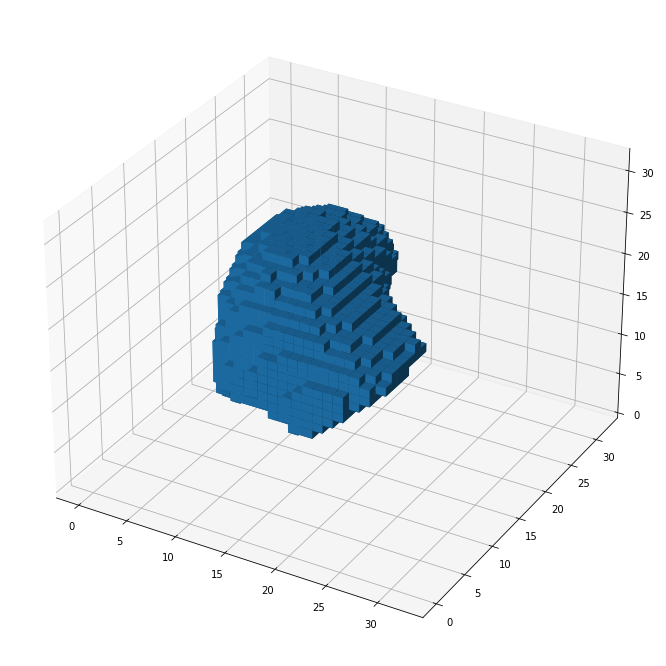

In [35]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.voxels(carved_voxel)

plt.show()

<IPython.core.display.Javascript object>


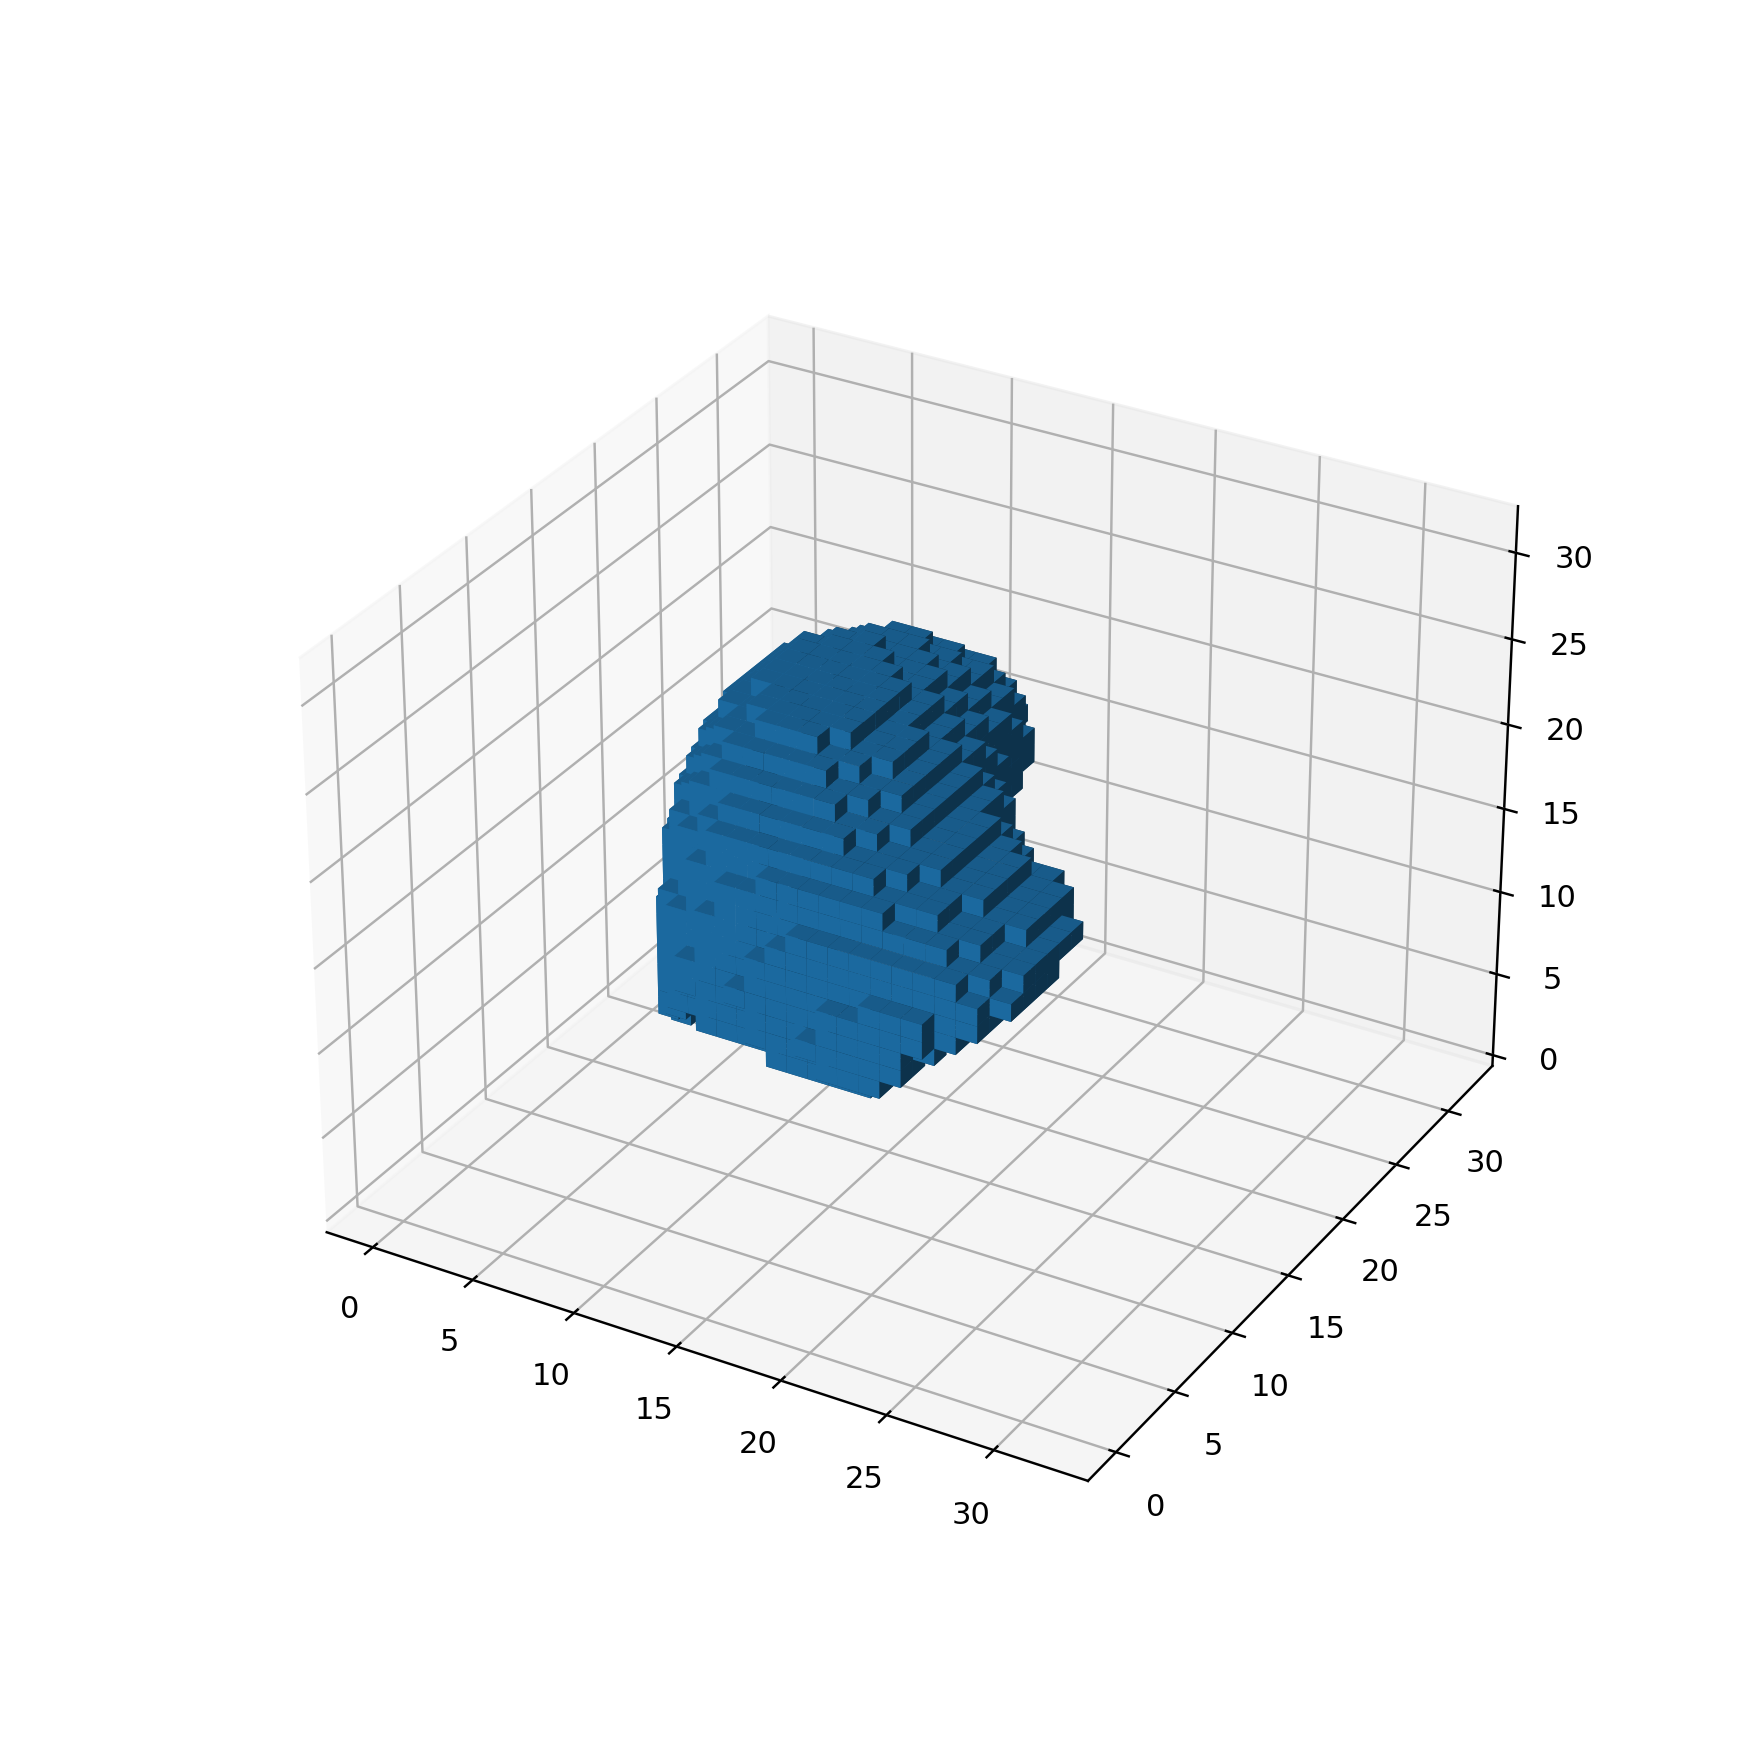

interactive(children=(FloatSlider(value=0.0, description='w', max=1.0), Output()), _dom_classes=('widget-inter…

In [36]:
%matplotlib notebook


fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection ="3d")
ax.voxels(mean_voxel_shape)

def update(w = 0.0):
    ax.clear()
    carved_voxel = np.zeros(mean_voxel_shape.shape)

    for i in range(32):
        for j in range(32):
            for k in range(32):
                if mean_voxel_shape[i,j,k] >= w:
                    carved_voxel[i,j,k] = 1
    
    ax.voxels(carved_voxel)
    fig.canvas.draw_idle()

interact(update, w = (0,1,0.1));